In [1]:
# Copyright (c) Nanjing University, Vision Lab.
# Jianqiang Wang (wangjq@smail.nju.edu.cn), Hao Zhu, Zhan Ma, Tong Chen, Haojie Liu, Qiu Shen; Nanjing University, Vision Lab.
# Chaofei Wang; Shanghai Jiao Tong University, Cooperative Medianet Innovation Center.
# Last update: 2019.10.27
# 2019.11.14

In [2]:
import random

In [3]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pylab  as plt
tf.enable_eager_execution()

/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/tf/lib/python3.6/site-packages

In [4]:
from mycodec_hyper import preprocess, postprocess, compress, decompress, \
write_binary_files, read_binary_files

# if necessary, maybe you should consider compression with low memory, which eocode each block respectively.
from mycodec_hyper import preprocess, postprocess, compress_more_less_mem, decompress_less_mem, \
write_binary_files_less_mem, read_binary_files_less_mem

In [5]:
import models.model_voxception as model
from models.entropy_model import EntropyBottleneck
from models.conditional_entropy_model import SymmetricConditional
from dataprocess.inout_points import load_ply_data, write_ply_data, load_points, save_points, points2voxels, voxels2points
from dataprocess.post_process import select_voxels
from myutils.gpcc_wrapper import gpcc_encode, gpcc_decode

In [6]:
# os.environ['CUDA_VISIBLE_DEVICES']=""

# set gpu.
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
config.gpu_options.allow_growth = True
config.log_device_placement=True
# config.device_count={'gpu':0}
sess = tf.Session(config=config)

## Compress

In [7]:
# input_file = 'testdata/GPCC_inanimate/Facade_00009_vox12.ply'
input_file = 'testdata/8iVFB/longdress_vox10_1300.ply'
scale = 1.
cube_size = 64
min_num = 64

res = 1024

In [8]:
cubes, cube_positions, points_numbers = preprocess(input_file, scale, cube_size, min_num)

===== Preprocess =====
Scaling: 0.0s
Partition: 10.8939s
Voxelization: 0.1651s
cubes shape: (202, 64, 64, 64, 1)
points numbers (sum/mean/max/min): 857600 4246 11450 78


point_numbers (min/max/mean):  78 11450 4245.544554455446


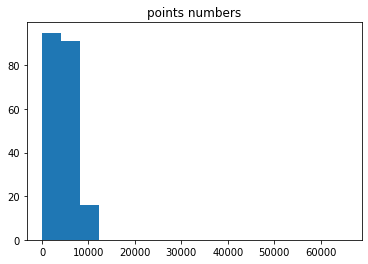

In [9]:
print('point_numbers (min/max/mean): ', points_numbers.min(), points_numbers.max(), points_numbers.mean())
plt.title('points numbers')
n, bins, patches = plt.hist(points_numbers, bins=16, range=(1, pow(2, 16)))
plt.show()

In [10]:
# model = 'model_voxception'
import models.model_voxception as model
# ckpt_dir = './checkpoints/hyper/a0.75b3/'
ckpt_dir = './checkpoints/hyper/a6b3/'

## compression required less GPU memory, encode each cube respectively

In [11]:
cubes.shape

(202, 64, 64, 64, 1)

In [12]:
# y_strings, y_min_vs, y_max_vs, y_shape, z_strings, z_min_v, z_max_v, z_shape, x_ds = \
# compress_less_mem(cubes, model, ckpt_dir, True)

In [13]:
start = time.time()
y_strings, y_min_vs, y_max_vs, y_shape, z_strings, z_min_v, z_max_v, z_shape, x_ds = \
compress_more_less_mem(cubes, model, ckpt_dir, True)
print(round(time.time() - start, 4))

===== Compress =====
0
Instructions for updating:
Colocations handled automatically by placer.
245.8868


In [14]:
filename = os.path.split(input_file)[-1][:-4]
rootdir = './compressed/'

In [15]:
bytes_strings, bytes_strings_head, bytes_strings_hyper, bytes_pointnums, bytes_cubepos = \
    write_binary_files_less_mem(
    filename, y_strings.numpy(), z_strings.numpy(), points_numbers, cube_positions,
    y_min_vs.numpy(), y_max_vs.numpy(), y_shape.numpy(), 
    z_min_v.numpy(), z_max_v.numpy(), z_shape.numpy(), rootdir)

===== Write binary files =====
Total file size (Bytes): 31513
Strings (Bytes): 23467
Strings head (Bytes): 422
Strings hyper (Bytes): 7130
Numbers of points (Bytes): 404
Positions of cubes (Bytes): 90


In [16]:
y_strings_d, z_strings_d, points_numbers_d, cube_positions_d, \
y_min_vs_d, y_max_vs_d, y_shape_d, z_min_v_d, z_max_v_d, z_shape_d = \
read_binary_files_less_mem(filename, rootdir)

===== Read binary files =====


In [17]:
# cubes_d = decompress_less_mem(y_strings_d, y_min_vs_d.astype('int32'), y_max_vs_d.astype('int32'), y_shape_d, 
#                      z_strings_d, z_min_v_d, z_max_v_d, z_shape_d, model, ckpt_dir)

## compression required more GPU memory, encode all cubes togrther

In [18]:
# y_strings, y_min_v, y_max_v, y_shape, z_strings, z_min_v, z_max_v, z_shape, x_ds = \
# compress(cubes, model, ckpt_dir, True)

# bytes_strings, bytes_strings_hyper, bytes_pointnums, bytes_cubepos = write_binary_files(
#     filename, y_strings.numpy(), z_strings.numpy(), points_numbers, cube_positions,
#     y_min_v.numpy(), y_max_v.numpy(), y_shape.numpy(), 
#     z_min_v.numpy(), z_max_v.numpy(), z_shape.numpy(), rootdir)

# y_strings_d, z_strings_d, points_numbers_d, cube_positions_d, \
# y_min_v_d, y_max_v_d, y_shape_d, z_min_v_d, z_max_v_d, z_shape_d = \
# read_binary_files(filename, rootdir)

# cubes_d = decompress(y_strings_d, y_min_v_d, y_max_v_d, y_shape_d, 
#                      z_strings_d, z_min_v_d, z_max_v_d, z_shape_d, model, ckpt_dir)

### check GPU error, if error, try CPU

In [19]:
# tf.reduce_max(tf.abs(cubes_d - x_ds))

In [20]:
cubes_d = x_ds

In [21]:
rho = 1.0
# output_file = './rec.ply'
output_file = filename + "_rec.ply"
print(output_file)

longdress_vox10_1300_rec.ply


In [22]:
# postprocess(output_file, cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, rho)

# cheat
postprocess(output_file, x_ds, points_numbers_d, cube_positions_d, scale, cube_size, rho)

===== Post process =====
Classify and extract points: 1.332s
Write point cloud to longdress_vox10_1300_rec.ply: 3.5596s


## Metrics

### BPP

In [23]:
def get_points_number(filedir):
    plyfile = open(filedir)

    line = plyfile.readline()
    while line.find("element vertex") == -1:
        line = plyfile.readline()
    number = float(line.split(' ')[-1][:-1])
    
    return number

In [24]:
N = get_points_number(input_file)
print(N)

857966.0


In [25]:
print("bpp: ", 8*(bytes_strings + bytes_strings_head + bytes_strings_hyper + bytes_pointnums + bytes_cubepos)/N)
print("strings: ", 8*bytes_strings/N, "strings_head: ", 8*bytes_strings_head/N, \
"strings_hyper: ", 8*bytes_strings_hyper/N, \
"points numbers: ", 8*bytes_pointnums/N, "cubes positions: ", 8*bytes_cubepos/N)

bpp:  0.2938391498031391
strings:  0.21881519780504122 strings_head:  0.003934887862689198 strings_hyper:  0.06648282099756866 points numbers:  0.0037670490439015067 cubes positions:  0.0008391940939384545


### pc_error

In [26]:
import subprocess

input_file_n = input_file[:-4]+'.ply'
subp=subprocess.Popen("myutils/pc_error_d" 
                      + ' -a ' + input_file
                      + ' -b ' + output_file
                      +' -n ' + input_file 
                      + ' --hausdorff=1 '
                      + " -r "+str(res-1), 
                      shell=True, stdout=subprocess.PIPE)

c=subp.stdout.readline()
while c:
    print(c)
    c=subp.stdout.readline()

print(subp.returncode)

b'PCC quality measurement software, version 0.13.4\n'
b'\n'
b'infile1:        testdata/8iVFB/longdress_vox10_1300.ply\n'
b'infile2:        longdress_vox10_1300_rec.ply\n'
b'normal1:        testdata/8iVFB/longdress_vox10_1300.ply\n'
b'singlePass:     0\n'
b'hausdorff:      1\n'
b'color:          0\n'
b'lidar:          0\n'
b'resolution:     1023\n'
b'dropDuplicates: 2\n'
b'neighborsProc:  1\n'
b'averageNormals: 1\n'
b'nbThreads:      1\n'
b'\n'
b'Verifying if the data is loaded correctly.. The last point is: 256 902 320\n'
b'Reading file 1 done.\n'
b'Normals loaded from file1.\n'
b'Verifying if the data is loaded correctly.. The last point is: 221 960 320\n'
b'Reading file 2 done.\n'
b'Imported intrinsic resoluiton: 1023\n'
b'Peak distance for PSNR: 1023\n'
b'Point cloud sizes for org version, dec version, and the scaling ratio: 857966, 857398, 0.999338\n'
b'Normals prepared.\n'
b'\n'
b'1. Use infile1 (A) as reference, loop over A, use normals on B. (A->B).\n'
b'   mse1      (p2point): 

In [40]:
import open3d as o3d

pcd = o3d.read_point_cloud(input_file)
o3d.estimate_normals(pcd, search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))

True

In [41]:
o3d.draw_geometries([pcd])

In [42]:
pcd_rec = o3d.read_point_cloud(output_file)
o3d.estimate_normals(pcd_rec, search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))
o3d.draw_geometries([pcd_rec])

In [43]:
# Move the original point cloud
pcd_rec.points = o3d.Vector3dVector(np.array(pcd_rec.points) + np.array([256, 0, 0]))

In [44]:
o3d.draw_geometries([pcd, pcd_rec])

---
## How to select optimal rho?

In [45]:
from myutils.pc_error_wrapper import pc_error
from myutils.pc_error_wrapper import get_points_number

In [46]:
def select_rho(item, input_file, output_file, input_file_n, 
               cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, res):

    steps = [0.05]*6+[0.10]*3
    MAX = 0
    rho = 1.0
    optimal_rho = 1.0

    for i, step in enumerate(steps):
        print('===== select rho =====')
        postprocess(output_file, cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, rho)
        results = pc_error(input_file, output_file, input_file_n, res, show=False)
        
        # record results.
        results["n_points"] = get_points_number(output_file)
        results["rho"] = rho
        if i == 0:
            all_results = results.copy(deep=True)
        else:
            all_results = all_results.append(results, ignore_index=True)
        

        PSNR = float(results[item])
        print('===== results: ', i, rho, item, PSNR)

        MAX = max(PSNR, MAX)
        if PSNR < MAX:
            break
        else:
            optimal_rho = rho

        if item == "mseF,PSNR (p2point)":
            rho += step
        elif item == "mseF,PSNR (p2plane)":
            rho -= step
        else:
            print('ERROR', item)
            break
    
    return optimal_rho, all_results

### pick rho for optimal D1 distortion

In [47]:
optimal_d1, all_results = select_rho("mseF,PSNR (p2point)", input_file, output_file, input_file_n, 
                        cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, res)

===== select rho =====
===== Post process =====
Classify and extract points: 0.7366s
Write point cloud to longdress_vox10_1300_rec.ply: 3.583s
===== measure PCC quality using `pc_error` version 0.13.4 22.3799
===== results:  0 1.0 mseF,PSNR (p2point) 73.3621
===== select rho =====
===== Post process =====
Classify and extract points: 0.484s
Write point cloud to longdress_vox10_1300_rec.ply: 3.7335s
===== measure PCC quality using `pc_error` version 0.13.4 22.9884
===== results:  1 1.05 mseF,PSNR (p2point) 72.9951


In [48]:
all_results

,mse1 (p2point),"mse1,PSNR (p2point)",mse1 (p2plane),"mse1,PSNR (p2plane)",h. 1(p2point),"h.,PSNR 1(p2point)",h. 1(p2plane),"h.,PSNR 1(p2plane)",mse2 (p2point),"mse2,PSNR (p2point)",...,mseF (p2point),"mseF,PSNR (p2point)",mseF (p2plane),"mseF,PSNR (p2plane)",h. (p2point),"h.,PSNR (p2point)",h. (p2plane),"h.,PSNR (p2plane)",n_points,rho
0,0.144764,73.3621,0.054476,77.6067,27.0,50.6551,5.59411,57.4914,0.138448,73.5559,...,0.144764,73.3621,0.061621,77.0714,27.0,50.6551,6.41906,56.8940,857398,1.00
1,0.118626,74.2269,0.045283,78.4094,26.0,50.8190,4.37311,58.5608,0.157529,72.9951,...,0.157529,72.9951,0.071011,76.4555,26.0,50.8190,7.36371,56.2978,900178,1.05


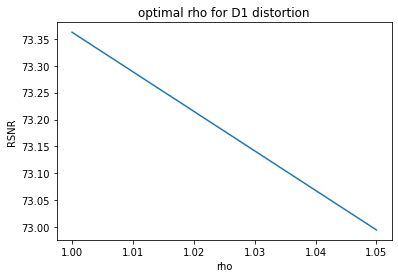

In [49]:
plt.plot(np.array(all_results["rho"][:]), np.array(all_results["mseF,PSNR (p2point)"][:]))
plt.title("optimal rho for D1 distortion")
_ = plt.xlabel('rho')
_ = plt.ylabel('RSNR')

### pick rho for optimal D2 distortion

In [50]:
optimal_d2, all_results = select_rho("mseF,PSNR (p2plane)", input_file, output_file, input_file_n, 
                        cubes_d, points_numbers_d, cube_positions_d, scale, cube_size, res)

===== select rho =====
===== Post process =====
Classify and extract points: 0.3534s
Write point cloud to longdress_vox10_1300_rec.ply: 3.5071s
===== measure PCC quality using `pc_error` version 0.13.4 22.7066
===== results:  0 1.0 mseF,PSNR (p2plane) 77.0714
===== select rho =====
===== Post process =====
Classify and extract points: 0.3596s
Write point cloud to longdress_vox10_1300_rec.ply: 3.373s
===== measure PCC quality using `pc_error` version 0.13.4 21.8672
===== results:  1 0.95 mseF,PSNR (p2plane) 76.8678


In [51]:
all_results

,mse1 (p2point),"mse1,PSNR (p2point)",mse1 (p2plane),"mse1,PSNR (p2plane)",h. 1(p2point),"h.,PSNR 1(p2point)",h. 1(p2plane),"h.,PSNR 1(p2plane)",mse2 (p2point),"mse2,PSNR (p2point)",...,mseF (p2point),"mseF,PSNR (p2point)",mseF (p2plane),"mseF,PSNR (p2plane)",h. (p2point),"h.,PSNR (p2point)",h. (p2plane),"h.,PSNR (p2plane)",n_points,rho
0,0.144764,73.3621,0.054476,77.6067,27.0,50.6551,5.59411,57.4914,0.138448,73.5559,...,0.144764,73.3621,0.061621,77.0714,27.0,50.6551,6.41906,56.8940,857398,1.00
1,0.176748,72.4952,0.064579,76.8678,37.0,49.2867,5.58361,57.4996,0.121043,74.1393,...,0.176748,72.4952,0.064579,76.8678,37.0,49.2867,5.95338,57.2211,814419,0.95


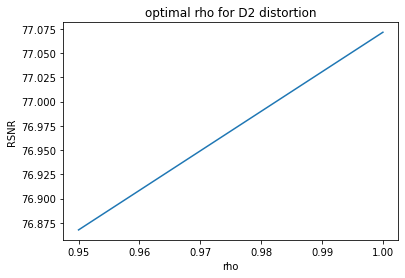

In [52]:
plt.plot(np.array(all_results["rho"][:]), np.array(all_results["mseF,PSNR (p2plane)"][:]))
plt.title("optimal rho for D2 distortion")
_ = plt.xlabel('rho')
_ = plt.ylabel('RSNR')